<a href="https://colab.research.google.com/github/pranchalkumar001/leukemia-detection-model/blob/main/inception_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install opendatasets

In [14]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mehradaria/leukemia')

Skipping, found downloaded files in "./leukemia" (use force=True to force download)


In [15]:
!nvidia-smi

Sat Sep  6 17:31:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             30W /   70W |    2168MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

IMPORT MODEL

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


IMPORT DATASET

In [17]:
train_dir = "/content/leukemia/Segmented"

PREPROCESS DATA

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


LOAD INCEPTION V3 MODEL

In [19]:
# Load pretrained InceptionV3 without top layers
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # freeze feature extractor

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(4, activation="softmax")(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

TRAIN MODEL

In [20]:
history = model.fit(train_gen, validation_data=val_gen, epochs=100)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 73s 669ms/step - accuracy: 0.6920 - loss: 0.7716 - val_accuracy: 0.7997 - val_loss: 0.5333
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 486ms/step - accuracy: 0.9130 - loss: 0.2452 - val_accuracy: 0.8613 - val_loss: 0.3986
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 519ms/step - accuracy: 0.9142 - loss: 0.2367 - val_accuracy: 0.8336 - val_loss: 0.4652
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 478ms/step - accuracy: 0.9262 - loss: 0.2042 - val_accuracy: 0.8552 - val_loss: 0.4314
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - accuracy: 0.9315 - loss: 0.1874 - val_accuracy: 0.8921 - val_loss: 0.3596
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 474ms/step - accuracy: 0.9345 - loss: 0.1831 - val_accuracy: 0.9153 - val_loss: 0.2893
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 484ms/step - accuracy: 0.9457 - loss: 0.1675 - val_accuracy: 0.9183 - val_loss: 0.2986
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 471ms/step - accuracy: 0.9459 - loss: 0.1578 - 

CHECK TRAING & VALIDATION ACCURACY

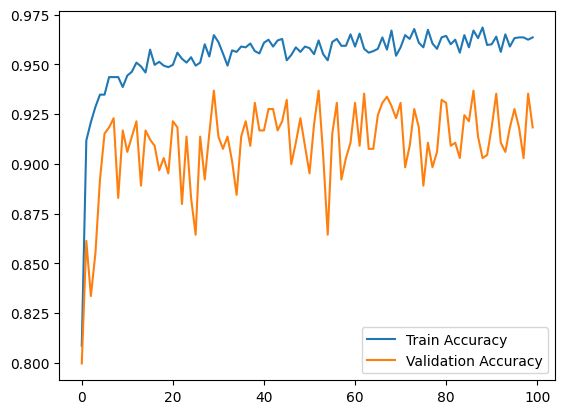

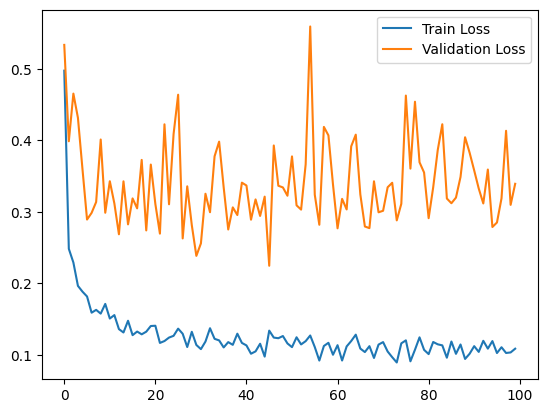

In [21]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

EVALUATION ON VALIDATION/TEST DATA

In [22]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.9385 - loss: 0.2976
Validation Accuracy: 92.45%


PREDICT ON A SINGLE IMAGE

In [23]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to one test image
img_path = "/content/leukemia/Segmented/Early/WBC-Malignant-Early-001.jpg" #now i take a image from Early dataset, for check it work or not

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
class_labels = list(train_gen.class_indices.keys())
print("Predicted Class:", class_labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Early


CONFUSION MATRIX

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions for validation set
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 626ms/step
Confusion Matrix:
 [[15 32 22 31]
 [35 58 59 45]
 [41 54 55 42]
 [35 46 37 42]]
              precision    recall  f1-score   support

      Benign       0.12      0.15      0.13       100
       Early       0.31      0.29      0.30       197
         Pre       0.32      0.29      0.30       192
         Pro       0.26      0.26      0.26       160

    accuracy                           0.26       649
   macro avg       0.25      0.25      0.25       649
weighted avg       0.27      0.26      0.27       649

